Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
#pickle_file = 'notMNIST.pickle'
pickle_file = 'notMNIST_noDupNorOvlp.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 28, 28) (438047,)
Validation set (15586, 28, 28) (15586,)
Test set (13645, 28, 28) (13645,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 784) (438047, 10)
Validation set (15586, 784) (15586, 10)
Test set (13645, 784) (13645, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

##### Model 1: 
Logistic regression with SGD

Set-up Model:

In [12]:
batch_size = 128

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
  #The question here is: Do we also want to take into account biases fro regularization?
  #"applying weight decay to the bias units usually makes only a small difference to the final network"
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases) )
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Run the model:

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.104467
Minibatch accuracy: 12.5%
Validation accuracy: 15.0%
Minibatch loss at step 500: 2.347745
Minibatch accuracy: 77.3%
Validation accuracy: 72.9%
Minibatch loss at step 1000: 1.452825
Minibatch accuracy: 84.4%
Validation accuracy: 74.1%
Minibatch loss at step 1500: 1.589714
Minibatch accuracy: 72.7%
Validation accuracy: 75.5%
Minibatch loss at step 2000: 1.175524
Minibatch accuracy: 76.6%
Validation accuracy: 76.3%
Minibatch loss at step 2500: 0.860617
Minibatch accuracy: 80.5%
Validation accuracy: 77.9%
Minibatch loss at step 3000: 0.580042
Minibatch accuracy: 89.1%
Validation accuracy: 78.3%
Test accuracy: 85.7%


Compared to assignment 2 (Logistic regression SGD at iteration 3000:

*Ass 2 no regu: Minibatch loss at step 3000: 0.578054
Minibatch accuracy: 86.7%
Validation accuracy: 76.1%
Test accuracy: 83.6%*

*Last L2 Regul only weights beta 5e-4: Minibatch loss at step 3000: 0.580042
Minibatch accuracy: 89.1%
Validation accuracy: 78.3%
Test accuracy: 85.7%*



##### Model 2:  
1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. 

In [8]:
batch_size = 128

hidden1_nodes = 1024

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden1_nodes]) ),
    'out': tf.Variable( tf.truncated_normal([hidden1_nodes, num_labels]) )
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden1_nodes])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  # Hidden fully connected layer with 256 neurons.
  layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  #Output layer applying relu to hiden layer
  logits_out = tf.matmul( tf.nn.relu(layer_1), weights['out']) + biases['out']
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                      + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']))
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization

    ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.matmul(tf_test_dataset, weights['h1']) + biases['b1']
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_1), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_1), weights['out']) + biases['out']
  
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

Let's Run the model: 

Initialized
Minibatch loss at step 0: 535.250305
Minibatch accuracy: 3.1%
Validation accuracy: 25.0%
Minibatch loss at step 500: 128.788483
Minibatch accuracy: 78.9%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 95.687538
Minibatch accuracy: 87.5%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 73.943321
Minibatch accuracy: 80.5%
Validation accuracy: 77.4%
Minibatch loss at step 2000: 58.023598
Minibatch accuracy: 81.2%
Validation accuracy: 78.3%
Test accuracy: 85.6%


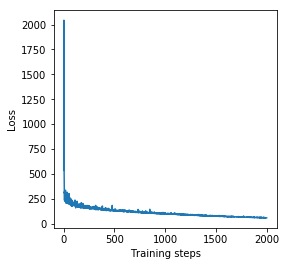

In [20]:
num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

Compared to assignment 2 (Logistic regression SGD at iteration 3000:

*Ass 2 NN: Minibatch loss at step 5000: 4.587700
Minibatch accuracy: 78.1%
Validation accuracy: 79.6%
Test accuracy: 86.6%*

*Last L2 Regul only weights and bias beta 5e-4: Minibatch loss at step 5000: 12.971046
Minibatch accuracy: 82.0%
Validation accuracy: 84.4%
Test accuracy: 90.5%
*

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

To run a few batches we will try by only running a small subset of batches. So batch size is the same, but we will only train with a small subset of batches (no going through the whole training dataset.

We will implement this by making the offset a random number between 0 and 10. Only first 10 batches on the data training set are used for training.

Let´s run the model Using the Setup of previous exercise.

Initialized
Minibatch loss at step 0: 527.359375
Minibatch accuracy: 5.5%
Validation accuracy: 36.1%
Minibatch loss at step 500: 127.361511
Minibatch accuracy: 99.2%
Validation accuracy: 75.0%
Minibatch loss at step 1000: 95.485588
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 1500: 74.362022
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2000: 57.911427
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2500: 45.099991
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3000: 35.122944
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3500: 27.352951
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 4000: 21.302094
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 4500: 16.589764
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 5000: 12.920185
Minibatch accuracy: 100.

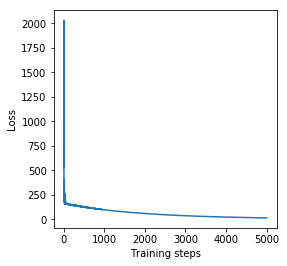

In [18]:

import matplotlib.pyplot as plt

num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the first 10 subsetes of 128 entries in dataset.
    offset = batch_size * np.random.choice(10)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

As we can see, The Minibatch accuracy is 100% (Actually this is like training with a smaller dataset).
However, Validation and test accuracy are lower.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Note that nn.dropout is only applied in train_layer_1. 

We will apply a probability of 0.5 to keep/dropout an activation (values that go from one layer to the next).

In [5]:
batch_size = 128

hidden1_nodes = 1024

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden1_nodes]) ),
    'out': tf.Variable( tf.truncated_normal([hidden1_nodes, num_labels]) )
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden1_nodes])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  # Hidden fully connected layer with 256 neurons.
  train_layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  train_layer_1 = tf.nn.dropout(train_layer_1, 0.5)
  #Output layer applying relu to hiden layer
  logits_out = tf.matmul( tf.nn.relu(train_layer_1), weights['out']) + biases['out']
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                      + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']))
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization

    ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.matmul(tf_test_dataset, weights['h1']) + biases['b1']
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_1), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_1), weights['out']) + biases['out']
  
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Let's run the Model.

Initialized
Minibatch loss at step 0: 647.199707
Minibatch accuracy: 15.6%
Validation accuracy: 30.8%
Minibatch loss at step 500: 141.209442
Minibatch accuracy: 71.9%
Validation accuracy: 76.5%
Minibatch loss at step 1000: 98.687836
Minibatch accuracy: 81.2%
Validation accuracy: 75.1%
Minibatch loss at step 1500: 78.025322
Minibatch accuracy: 68.8%
Validation accuracy: 76.7%
Minibatch loss at step 2000: 62.269276
Minibatch accuracy: 68.8%
Validation accuracy: 77.4%
Minibatch loss at step 2500: 45.906364
Minibatch accuracy: 72.7%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 34.820324
Minibatch accuracy: 81.2%
Validation accuracy: 78.7%
Minibatch loss at step 3500: 27.925144
Minibatch accuracy: 73.4%
Validation accuracy: 80.3%
Minibatch loss at step 4000: 21.562328
Minibatch accuracy: 77.3%
Validation accuracy: 80.6%
Minibatch loss at step 4500: 16.728735
Minibatch accuracy: 78.1%
Validation accuracy: 82.4%
Minibatch loss at step 5000: 13.389703
Minibatch accuracy: 80.5%
Valid

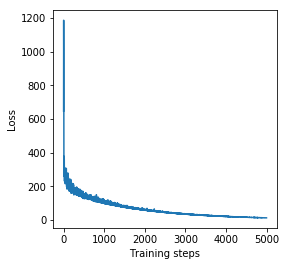

In [20]:
num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

Dropout technique seems to improve the model. Test accuray is now aroun 89% when for Problem 1 was around 85%.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


##### 4.1. Set Up the Model
###### First Approach 
Multilayer Neural Network with 4 hidden layers of same number of neurons each. 

Weights initialized with deviation square root of (2 / input activations to layer)

RELU function for each layer activations.

Dropout technique at each layer activations. Only during training.

L2 Regulariation including also biases.

Dynamic learning rate.




In [43]:
batch_size = 128

image_size = 28
num_labels = 10

num_steps = 250001

MODEL_NAME = "madel_layer1024_step250K"

hidden_layer_nodes = {
    'h1' : 1024,
    'h2' : 1024,
    'h3' : 1024,
    'h4' : 512 
}

_BETA_REGUL = 5e-5 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden_layer_nodes['h1'] ] , 
                                           stddev = np.sqrt(2.0 / (image_size * image_size))) ),
    'h2': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h1'], hidden_layer_nodes['h2'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h1'] )) ),
    'h3': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h2'], hidden_layer_nodes['h3'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h2'] )) ),
    'h4': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h3'], hidden_layer_nodes['h4'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h3'] )) ),
    'out': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h4'], num_labels] , 
                                            stddev= np.sqrt(2.0 / hidden_layer_nodes['h4'] )) ),
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden_layer_nodes['h1'] ])),
    'b2': tf.Variable(tf.zeros([hidden_layer_nodes['h2'] ])),
    'b3': tf.Variable(tf.zeros([hidden_layer_nodes['h3'] ])),
    'b4': tf.Variable(tf.zeros([hidden_layer_nodes['h4'] ])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  train_layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  train_layer_1 = tf.nn.dropout(tf.nn.relu(train_layer_1), 0.5)
    
  train_layer_2 = tf.add(tf.matmul(train_layer_1, weights['h2']) , biases['b2'])
  train_layer_2 = tf.nn.dropout(tf.nn.relu(train_layer_2), 0.7)
    
  train_layer_3 = tf.add(tf.matmul(train_layer_2, weights['h3']) , biases['b3'])
  train_layer_3 = tf.nn.dropout(tf.nn.relu(train_layer_3), 0.7)
    
  train_layer_4 = tf.add(tf.matmul(train_layer_3, weights['h4']) , biases['b4'])
  train_layer_4 = tf.nn.dropout(tf.nn.relu(train_layer_4), 0.9)
    
  logits_out = tf.add(tf.matmul( train_layer_4, weights['out']) , biases['out'])
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regul = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                       + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(biases['b2'])
                       + tf.nn.l2_loss(weights['h3']) + tf.nn.l2_loss(biases['b3'])
                       + tf.nn.l2_loss(weights['h4']) + tf.nn.l2_loss(biases['b4'])
                       + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']) )
    
  loss += _BETA_REGUL * l2_regul
  
  # Optimizer. Exponential decay of learning rate
  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, # Base learning rate. Start big to learn fast at the beginning
                                             global_step * batch_size,
                                             num_steps,  # tf_train_labels.shape[0],# Decay step.
                                             0.97,                # Decay rate.
                                             staircase=True)

  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
  

  ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.add(tf.matmul(tf_test_dataset, weights['h1']) , biases['b1'])
  test_layer_2 = tf.add(tf.matmul(tf.nn.relu(test_layer_1), weights['h2']) , biases['b2'])
  test_layer_3 = tf.add(tf.matmul(tf.nn.relu(test_layer_2), weights['h3']) , biases['b3'])
  test_layer_4 = tf.add(tf.matmul(tf.nn.relu(test_layer_3), weights['h4']) , biases['b4'])
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_4), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_layer_2 = tf.add(tf.matmul(tf.nn.relu(valid_layer_1), weights['h2']) , biases['b2'])
  valid_layer_3 = tf.add(tf.matmul(tf.nn.relu(valid_layer_2), weights['h3']) , biases['b3'])
  valid_layer_4 = tf.add(tf.matmul(tf.nn.relu(valid_layer_3), weights['h4']) , biases['b4'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_4), weights['out']) + biases['out']

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

  #Saver in order to save a fully trained model.
  saver = tf.train.Saver()

Let´s run the Model:

Initialized
Minibatch loss at step 0: 2.641196
Minibatch accuracy: 13.3%
Validation accuracy: 12.6%
Minibatch loss at step 500: 0.641326
Minibatch accuracy: 85.2%
Validation accuracy: 83.1%
Minibatch loss at step 1000: 0.583873
Minibatch accuracy: 87.5%
Validation accuracy: 83.9%
Minibatch loss at step 1500: 0.719728
Minibatch accuracy: 81.2%
Validation accuracy: 84.4%
Minibatch loss at step 2000: 0.640030
Minibatch accuracy: 84.4%
Validation accuracy: 85.1%
Minibatch loss at step 2500: 0.641124
Minibatch accuracy: 83.6%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 0.492197
Minibatch accuracy: 89.8%
Validation accuracy: 86.3%
Minibatch loss at step 3500: 0.606868
Minibatch accuracy: 83.6%
Validation accuracy: 86.6%
Minibatch loss at step 4000: 0.571099
Minibatch accuracy: 86.7%
Validation accuracy: 86.9%
Minibatch loss at step 4500: 0.589196
Minibatch accuracy: 85.9%
Validation accuracy: 86.8%
Minibatch loss at step 5000: 0.609385
Minibatch accuracy: 84.4%
Validation accurac

Validation accuracy: 90.6%
Minibatch loss at step 45000: 0.404746
Minibatch accuracy: 89.1%
Validation accuracy: 90.8%
Minibatch loss at step 45500: 0.328594
Minibatch accuracy: 90.6%
Validation accuracy: 90.7%
Minibatch loss at step 46000: 0.379374
Minibatch accuracy: 90.6%
Validation accuracy: 90.9%
Minibatch loss at step 46500: 0.392736
Minibatch accuracy: 89.8%
Validation accuracy: 91.0%
Minibatch loss at step 47000: 0.297079
Minibatch accuracy: 93.8%
Validation accuracy: 90.8%
Minibatch loss at step 47500: 0.289522
Minibatch accuracy: 94.5%
Validation accuracy: 90.8%
Minibatch loss at step 48000: 0.453555
Minibatch accuracy: 87.5%
Validation accuracy: 90.9%
Minibatch loss at step 48500: 0.459894
Minibatch accuracy: 88.3%
Validation accuracy: 90.8%
Minibatch loss at step 49000: 0.438117
Minibatch accuracy: 89.8%
Validation accuracy: 90.8%
Minibatch loss at step 49500: 0.416990
Minibatch accuracy: 91.4%
Validation accuracy: 90.7%
Minibatch loss at step 50000: 0.356813
Minibatch accu

Minibatch loss at step 89500: 0.434537
Minibatch accuracy: 90.6%
Validation accuracy: 91.7%
Minibatch loss at step 90000: 0.226084
Minibatch accuracy: 94.5%
Validation accuracy: 91.6%
Minibatch loss at step 90500: 0.280629
Minibatch accuracy: 92.2%
Validation accuracy: 91.7%
Minibatch loss at step 91000: 0.282822
Minibatch accuracy: 93.0%
Validation accuracy: 91.8%
Minibatch loss at step 91500: 0.346846
Minibatch accuracy: 90.6%
Validation accuracy: 91.6%
Minibatch loss at step 92000: 0.358275
Minibatch accuracy: 90.6%
Validation accuracy: 91.7%
Minibatch loss at step 92500: 0.449130
Minibatch accuracy: 87.5%
Validation accuracy: 91.6%
Minibatch loss at step 93000: 0.258279
Minibatch accuracy: 93.8%
Validation accuracy: 91.7%
Minibatch loss at step 93500: 0.262607
Minibatch accuracy: 95.3%
Validation accuracy: 91.7%
Minibatch loss at step 94000: 0.501349
Minibatch accuracy: 88.3%
Validation accuracy: 91.7%
Minibatch loss at step 94500: 0.252963
Minibatch accuracy: 95.3%
Validation accu

Validation accuracy: 92.1%
Minibatch loss at step 134000: 0.280651
Minibatch accuracy: 93.8%
Validation accuracy: 92.0%
Minibatch loss at step 134500: 0.237110
Minibatch accuracy: 94.5%
Validation accuracy: 92.0%
Minibatch loss at step 135000: 0.209707
Minibatch accuracy: 96.1%
Validation accuracy: 92.1%
Minibatch loss at step 135500: 0.394420
Minibatch accuracy: 93.0%
Validation accuracy: 92.1%
Minibatch loss at step 136000: 0.285088
Minibatch accuracy: 93.8%
Validation accuracy: 92.1%
Minibatch loss at step 136500: 0.254633
Minibatch accuracy: 95.3%
Validation accuracy: 92.0%
Minibatch loss at step 137000: 0.322916
Minibatch accuracy: 93.0%
Validation accuracy: 92.1%
Minibatch loss at step 137500: 0.322835
Minibatch accuracy: 93.0%
Validation accuracy: 92.1%
Minibatch loss at step 138000: 0.232762
Minibatch accuracy: 94.5%
Validation accuracy: 92.0%
Minibatch loss at step 138500: 0.214555
Minibatch accuracy: 96.1%
Validation accuracy: 92.0%
Minibatch loss at step 139000: 0.183989
Min

Minibatch loss at step 178000: 0.303861
Minibatch accuracy: 91.4%
Validation accuracy: 92.3%
Minibatch loss at step 178500: 0.355348
Minibatch accuracy: 93.8%
Validation accuracy: 92.3%
Minibatch loss at step 179000: 0.243735
Minibatch accuracy: 93.0%
Validation accuracy: 92.2%
Minibatch loss at step 179500: 0.214143
Minibatch accuracy: 95.3%
Validation accuracy: 92.3%
Minibatch loss at step 180000: 0.278917
Minibatch accuracy: 93.8%
Validation accuracy: 92.4%
Minibatch loss at step 180500: 0.166619
Minibatch accuracy: 96.9%
Validation accuracy: 92.3%
Minibatch loss at step 181000: 0.237442
Minibatch accuracy: 93.0%
Validation accuracy: 92.3%
Minibatch loss at step 181500: 0.193069
Minibatch accuracy: 96.9%
Validation accuracy: 92.4%
Minibatch loss at step 182000: 0.236562
Minibatch accuracy: 94.5%
Validation accuracy: 92.3%
Minibatch loss at step 182500: 0.304757
Minibatch accuracy: 91.4%
Validation accuracy: 92.3%
Minibatch loss at step 183000: 0.293904
Minibatch accuracy: 93.8%
Vali

Validation accuracy: 92.5%
Minibatch loss at step 222500: 0.242966
Minibatch accuracy: 93.8%
Validation accuracy: 92.4%
Minibatch loss at step 223000: 0.198406
Minibatch accuracy: 94.5%
Validation accuracy: 92.5%
Minibatch loss at step 223500: 0.185774
Minibatch accuracy: 95.3%
Validation accuracy: 92.4%
Minibatch loss at step 224000: 0.229499
Minibatch accuracy: 96.1%
Validation accuracy: 92.5%
Minibatch loss at step 224500: 0.256938
Minibatch accuracy: 93.0%
Validation accuracy: 92.4%
Minibatch loss at step 225000: 0.195450
Minibatch accuracy: 96.9%
Validation accuracy: 92.5%
Minibatch loss at step 225500: 0.169025
Minibatch accuracy: 96.9%
Validation accuracy: 92.5%
Minibatch loss at step 226000: 0.289858
Minibatch accuracy: 91.4%
Validation accuracy: 92.4%
Minibatch loss at step 226500: 0.299234
Minibatch accuracy: 93.0%
Validation accuracy: 92.5%
Minibatch loss at step 227000: 0.142107
Minibatch accuracy: 97.7%
Validation accuracy: 92.4%
Minibatch loss at step 227500: 0.180734
Min

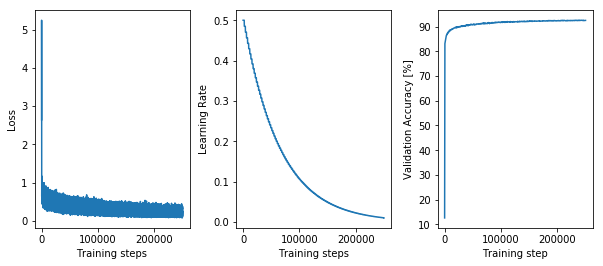

In [44]:
losses = []
learn_rate = []
valid_acc = []
valid_acc_x = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #print("Iteration {} ... step {} loss {}".format(step, global_step.eval() , l))
        
    #Monitoring the Model
    losses.append(l)
    learn_rate.append(learning_rate.eval()) 
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Validation accuracy: %.1f%%" % val_acc)
      valid_acc.append(val_acc)
      valid_acc_x.append(step)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  
  save_path = saver.save(session, "./saved_models/" + MODEL_NAME + ".ckpt")
  print("Model saved in path: {}".format(save_path))


# Show the loss over time.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
#line_x_range = (-4, 6)
ax2.plot(range(0, num_steps), learn_rate)
ax2.set_ylabel("Learning Rate")
ax2.set_xlabel("Training steps")
ax3.plot(valid_acc_x, valid_acc)
ax3.set_ylabel("Validation Accuracy [%]")
ax3.set_xlabel("Training step")
plt.show()

With layer size 1024 - 512 -521 - 256  and steps 250001 -> Test accuracy 96.8% !
